# **Avance 3. Baseline**

## **Equipo #5**

**Integrantes y matriculas**

* Isaac Manriquez Calderon - A01206674
* Marcos Eduardo Garcia Ortiz - A01276213
* Jesus David Talamantes Morales - A01706335

## Introducción

**¿Qué algoritmo se puede utilizar como baseline para predecir las variables objetivo?**

lorem ipsum

**¿Se puede determinar la importancia de las características para el modelo generado?**
Recuerden que incluir características irrelevantes puede afectar negativamente el rendimiento del modelo y aumentar la complejidad sin beneficios sustanciales.

Sí, es posible determinar la importancia de las características en el modelo que se ha generado. Aunque en nuestro contexto se extrajeron coeficientes de DWT y sus estadísticas a partir de las coordenadas x e 𝑦 de cada trazo, ahora existen varias técnicas que permiten evaluar qué tan relevantes son estas características (o incluso subconjuntos de ellas) para la toma de decisiones del modelo. Un enfoque en el que podemos trabajar es en la interpretación en el contexto de la señal embebida de marca de agua por ejemplo, puede que algunas estadisticas obentidas de los coeficientes de la DWT capturen patrones o irregularidades en la forma del trazo que sean cruciales para identificar o verificar la marca de agua, pudiendo mezclar aleatoriamente los valores de una característica en el conjunto de datos y medir el impacto en el rendimiento del modelo o usar. 

In [25]:
# Importar Librerias.
# Comando para recargar cambios en librerias automaticamente.
%load_ext autoreload 
%autoreload 2
import sys, os
from pathlib import Path
sys.path.append(os.path.abspath(os.path.join('..')))

# Librerias generales de matematicas
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import shap

# Librerias Locales del Repositorio.
from watermark.features import Utilities
from watermark.dataset import DataHandler

# Librerias de Machine Learning.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import pad_sequences  # Para ajustar secuencias de entrada a una longitud específica

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Cargamos los datos.
dh = DataHandler() # Objeto manejador de datos.
data_dict = dh.load_data(Path("../data/raw"), "emothaw_data.pkl")

2025-02-09 19:41:38.309 | INFO     | watermark.dataset:load_data:51 - Loading data from ..\data\raw\emothaw_data.pkl
2025-02-09 19:41:38.483 | SUCCESS  | watermark.dataset:load_data:56 - Data loaded successfully from ..\data\raw\emothaw_data.pkl


## Manejo de Datos

In [3]:
# Obtener los datos de interes del dataset.
x_data_in = {} # Diccionario de Puntos en X por tarea.
y_data_in = {} # Diccionario de Puntos en Y por Tarea.
p_data_in = {} # Diccionario de Presion en cada momento por tarea.
for key in data_dict.keys():
    x_data_in[key] = [serie.X for serie in data_dict[key]] 
    y_data_in[key] = [serie.Y for serie in data_dict[key]] 
    p_data_in[key] = [serie.Pressure for serie in data_dict[key]] 


In [4]:
# Generamos una copia en forma de lista de los datos en los diccionarios.
names_list = list(data_dict.keys())
list_data_x = [x_data_in[key] for key in names_list]
list_data_y = [y_data_in[key] for key in names_list]
list_data_p = [p_data_in[key] for key in names_list]
print("Número de Usuarios:", len(list_data_x))
print("Número de Tareas realizadas:", len(list_data_x[0]))
print("Número de Muestras por Tarea:", len(list_data_x[0][0]))

Número de Usuarios: 7
Número de Tareas realizadas: 129
Número de Muestras por Tarea: 1474


- A continuación queremos estandarizar la longitud de todas las tareas, por lo que es necesario cortar algunas que no cumplan con nuestro largo máximo (1500) por lo que usaremos la función "get_extended_data" para esta tarea. De igual manera utilizamos una lista de strides para mantener una proporción similar en las muestras que requieran ser recortadas.

In [5]:
strides=[600, 1500, 1300, 100, 50, 1200, 900] # Estos valores se seleccionaron para mantener una proporción similar de muestras de cada una de las tareas
limit_len = 1500  # Longitud límite de las secuencias utilizadas para el entrenamiento de las redes
# Obtenemos las secuencias extendidas de las variables X, Y y Pressure
sequences_list_x = dh.get_extended_data(list_data_x, strides, limit_len)
sequences_list_y = dh.get_extended_data(list_data_y, strides, limit_len)
sequences_list_p = dh.get_extended_data(list_data_p, strides, limit_len)


Text(0.5, 1.0, 'Secuencia de Usuario 1, Tarea 2, X')

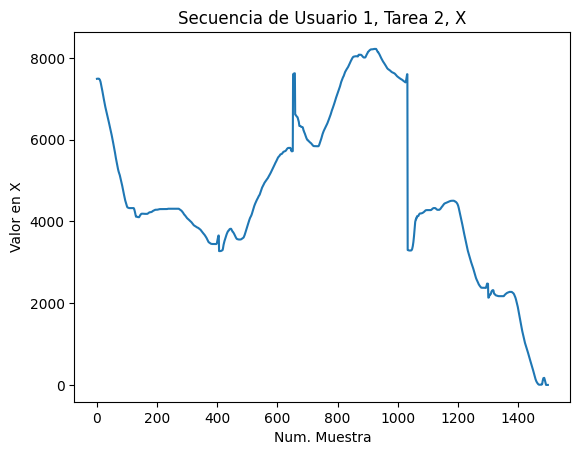

In [6]:
# Graficamos una secuencia de puntos X despues de implementar el proceso de extension.
plt.plot(sequences_list_x[0][1])
plt.xlabel("Num. Muestra")
plt.ylabel("Valor en X")
plt.title("Secuencia de Usuario 1, Tarea 2, X")   

- Aplicamos un padding (Añadir una secuencia de ceros) para estandarizar algunas señales que debido al proceso de extensión anterior no quedaron con la longitud deseada.

In [7]:
# Estandarizamos todas las señales.
x_data =[]
y_data = []
p_data = []

for i, x in enumerate(sequences_list_x): x_data.append(pad_sequences(x, maxlen=limit_len, padding='post', dtype='float64', truncating='post'))
for i, y in enumerate(sequences_list_y): y_data.append(pad_sequences(y, maxlen=limit_len, padding='post', dtype='float64', truncating='post'))
for i, p in enumerate(sequences_list_p): p_data.append(pad_sequences(p, maxlen=limit_len, padding='post', dtype='float64', truncating='post'))



In [8]:
# Combinar las secuencias de todas las tareas en un solo arreglo
# Apilar secuencias de las tareas verticalmente para cada variable.
x_tasks_data = np.vstack(x_data) 
y_tasks_data = np.vstack(y_data) 
p_tasks_data = np.vstack(p_data) 

print(f'Dimensiones finales para X: {x_tasks_data.shape}')
print(f'Dimensiones finales para Y: {y_tasks_data.shape}')
print(f'Dimensiones finales para Pressure: {p_tasks_data.shape}')

Dimensiones finales para X: (2177, 1500)
Dimensiones finales para Y: (2177, 1500)
Dimensiones finales para Pressure: (2177, 1500)


## Generación de Watermarks

In [12]:
# Generamos un objeto de utilities para las funciones.
util = Utilities()

In [13]:
# Sacamos las caracterisitcas "Wavelet" para cada una de las tareas agrupadas 
signs_x_wavelet = np.array([util.sign2wavelet(firma) for firma in x_tasks_data])
signs_y_wavelet = np.array([util.sign2wavelet(firma) for firma in y_tasks_data])

In [14]:
# Concatenar características X e Y
firmas_wavelet = np.hstack([signs_x_wavelet, signs_y_wavelet])
num_firmas = firmas_wavelet.shape[0]
print("Forma de las características extraídas:", firmas_wavelet.shape)

Forma de las características extraídas: (2177, 36)


### Generación de timestamps diferentes para marcar los trazos de cada tarea 

In [15]:
# Generamos 100 fechas diferentes utilizando una funcion.
dates_list = util.dates_generator(100)
print("Fecha de Prueba: ", dates_list[50])
# Mandamos llamar una funcion para generar un diccionario de hashes para cada fecha
dates_hashes = {date:util.hashear_fecha(date) for date in dates_list} 
fechas_lista = list(dates_hashes.items())

print("Ejemplo de fechas generadas y sus hashes:")
for i in range(3):
    print(f"Fecha: {fechas_lista[i][0]}, Hash: {fechas_lista[i][1][:5]}...")  # Muestra los primeros valores del hash

Fecha de Prueba:  2004/01/01 18:59:51
Ejemplo de fechas generadas y sus hashes:
Fecha: 2013/01/14 23:16:35, Hash: [146 187  62  93  13]...
Fecha: 1998/02/26 07:44:13, Hash: [144  86  47 190 241]...
Fecha: 2022/08/15 12:51:42, Hash: [108 208 128  61 226]...


In [16]:
# Generamos una lista de aleatoria utilizando las 100 fechas creadas.
fechas_asignadas = random.choices(fechas_lista, k=num_firmas)
hashes_entrenamiento = np.array([hash for _, hash in fechas_asignadas])
print("Forma de los hashes de entrenamiento:", hashes_entrenamiento.shape)  # Debe ser (2177, 32)

Forma de los hashes de entrenamiento: (2177, 32)


##  Prototipo Inicial de Red Neuronal Generadora. (Encoder)

- Inserte explicación sobre los hashes y las caracteristicas de las señales.

In [17]:
input_dim = firmas_wavelet.shape[1]  # Número de características extraídas - 36
hash_dim = hashes_entrenamiento.shape[1]  # 32 valores del hash - 36

# Definir la red neuronal generadora
inputs = keras.Input(shape=(input_dim,))
encoded = layers.Dense(128, activation="relu")(inputs)
encoded = layers.Dense(64, activation="relu")(encoded)
encoded = layers.Dense(hash_dim, activation="sigmoid")(encoded)  # 32 valores de salida

modelo_generador = keras.Model(inputs, encoded)
modelo_generador.compile(optimizer="adam", loss="mse")

# Entrenamiento con múltiples fechas
modelo_generador.fit(firmas_wavelet, hashes_entrenamiento, epochs=200, batch_size=16, verbose=1)


Epoch 1/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 21569.6484  
Epoch 2/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 21377.8672
Epoch 3/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 21327.5020
Epoch 4/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 21365.4277
Epoch 5/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 21518.4766
Epoch 6/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 21433.7520
Epoch 7/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 21429.2988
Epoch 8/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 21562.5352
Epoch 9/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 21440.8027
Epoch 10/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 21442.2285
Epoch 11/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 21452.4004
Epoch 12/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 21398.0996
Epoch 13/200
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 21351.7930
Epoch 14/200
137/137 ━━━━━━━━━━━━━

**¿El modelo está sub/sobreajustando los datos de entrenamiento?**

¿Cuál es la métrica adecuada para este problema de negocio? 

La métrica adecuada debe evaluar dos aspectos fundamentales en el embebido de marcas de agua en señales de trazos:<br>

**Robustez/Exactitud en la Extracción:**<br>
Es crucial que, aun en presencia de ruido, ataques o manipulaciones, la marca de agua pueda extraerse de forma fiable.

**Imperceptibilidad/Fidelidad:**<br>
La marca de agua debe estar embebida de tal forma que la calidad de la señal original (el trazo) no se degrade de forma apreciable. Para este fin, se suelen utilizar métricas que comparen la señal original con la señal modificada, tal como:<br>

* Error Cuadrático Medio (MSE) o Error de Pico (PSNR, en contextos de imagen): Mide la diferencia entre la señal original y la señal con marca de agua.

Por otra parte y debido a que el objetivo final es determinar si existe una marca o no, para demostrar su rendimiento conforme a las siguientes metricas: 

* Accuracy: Nos indicaría el porcentaje de bits que se han clasificado correctamente.
* Precision: Evaluaría la proporción de bits positivos extraídos correctamente frente a todos los bits positivos extraídos.

Con el analisis desde estas metricas vamos a poder evaluar el rendimiento de nuestras redes generadora y decodificadora desde diferentes ángulos.

¿Cuál debería ser el desempeño mínimo a obtener? jESUS

## Conclusiones 


Jesus y tuneo del codigo